### Content Based Filtering
They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

### Plot description based Recommender

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import packages and data

dframe_1 = pd.read_csv('data/tmdb_5000_credits.csv')
dframe_2 = pd.read_csv('data/tmdb_5000_movies.csv')

In [2]:
dframe_1.columns = ['id', 'title', 'cast', 'crew']
dframe_2 = dframe_2.merge(dframe_1, on='id')

In [3]:
dframe_2['overview'].head(3)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
Name: overview, dtype: object

### TF-IDF
we're using the TF-IDF approach 
the overall importance of each word to the document in which they appear is TF * IDF
TF(term frequency) = (term instances / total instances)
IDF(inverse document frequency) = log(number of documents / documents with term)

this will give a matrix where each column represents a word that appear at least once in the document,
and each row represents a movie

This is done to reduce the importance of words that occur frequently in plot overviews and therefore their importance in computing the final similarity score.


In [4]:
# Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

# Replace NaN with an empty string
dframe_2['overview'] = dframe_2['overview'].fillna('')

# Construct the required TF-IDF matrix bu fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(dframe_2['overview'])

# Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

we will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies.

we use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate mathematically.

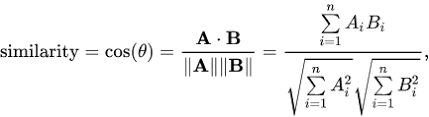

In [5]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [6]:
# We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies.
# Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices.
# In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

# Construct a reverse map of indices and movie titles
indices = pd.Series(dframe_2.index, index=dframe_2['title_y']).drop_duplicates()


In [7]:
# Function takes in movie title as input and outputs most similar movies

def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwise similarity scores of all movies with that movei
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort the movie based on similartiy scores
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 most similar movies
    return dframe_2['title_y'].iloc[movie_indices]

In [8]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title_y, dtype: object

In [9]:
get_recommendations('Avatar')

3604                       Apollo 18
2130                    The American
634                       The Matrix
1341            The Inhabited Island
529                 Tears of the Sun
1610                           Hanna
311     The Adventures of Pluto Nash
847                         Semi-Pro
775                        Supernova
2628             Blood and Chocolate
Name: title_y, dtype: object

While our system has done a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.

### Credits, Genres and Keywords Based Recommender

We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.

From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure

In [10]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']

for feature in features:
    dframe_2[feature] = dframe_2[feature].apply(literal_eval)

In [11]:
# Get the director's name from the crew feature. If the director is not listed, return NaN

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
        
    return np.nan

In [12]:
# Return the list top 3 elements or entire list; whichever is more.

def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        # Check if more than 3 elements exist.
        #If yes, return only first three.
        #If no, return entire list.
        
        if len(names) > 3:
            names = names[:3]
            
        return names
    # Return empty list in case of missing/malformed data
    return []

In [13]:
# Define new director, cast, genres and keywords features that are in a suitable form
dframe_2['director'] = dframe_2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']

for feature in features:
    dframe_2[feature] = dframe_2[feature].apply(get_list)

In [14]:
dframe_2[['title_y', 'cast', 'director', 'keywords', 
         'genres']].head(3)

,title_y,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [15]:
# Function to convert all strings to lower case and strip names of space

def clean_data(x):
    if isinstance(x, list):
        return[str.lower(i.replace(" ", "")) for i in x]
    else:
        # Check if director exists.
        #If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [16]:
# Apply clean_data function to feature
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    dframe_2[feature] = dframe_2[feature].apply(clean_data)

In [17]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

dframe_2['soup'] = dframe_2.apply(create_soup, axis=1)

In [18]:
# Import CountVectorizer and create count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(dframe_2['soup'])

In [19]:
# Compute the Cosine Similarity matrix based on the count_matrix

from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [20]:
# Reset index of our main DataFrame and construct reverse mapping as before
dframe_2 = dframe_2.reset_index()
indices = pd.Series(dframe_2.index, index = dframe_2['title_y'])

In [21]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title_y, dtype: object

In [22]:
get_recommendations('The Godfather', cosine_sim2)

867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: title_y, dtype: object

We see that our recommender has been successful in capturing more information due to more metadata and has given us (arguably) better recommendations. It is more likely that Marvels or DC comics fans will like the movies of the same production house. Therefore, to our features above we can add production_company . We can also increase the weight of the director , by adding the feature multiple times in the soup.